# Experiment 10: Solving a Markov Decision Process (MDP)


In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Task 1: Define the GridWorld MDP

# Grid dimensions
ROWS = 3
COLS = 4

# Define all states (excluding wall)
states = []
for r in range(ROWS):
    for c in range(COLS):
        if (r, c) != (1, 1):  # Exclude wall
            states.append((r, c))

# Terminal states
GOAL = (0, 3)
PIT = (1, 3)
terminal_states = {GOAL, PIT}

# Wall
WALL = (1, 1)

# Actions
actions = ['up', 'down', 'left', 'right']

# Rewards
def get_reward(state):
    if state == GOAL:
        return 1
    elif state == PIT:
        return -1
    else:
        return -0.04

# Discount factor
gamma = 0.99

print(f"Total states: {len(states)}")
print(f"States: {states}")
print(f"Terminal states: {terminal_states}")

Total states: 11
States: [(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3)]
Terminal states: {(0, 3), (1, 3)}


In [8]:

def get_next_state_deterministic(state, action):
    """Get the next state for a deterministic action (without probability)."""
    r, c = state
    
    if action == 'up':
        next_state = (r - 1, c)
    elif action == 'down':
        next_state = (r + 1, c)
    elif action == 'left':
        next_state = (r, c - 1)
    elif action == 'right':
        next_state = (r, c + 1)
    else:
        next_state = state
    
    # Check if next state is valid (within bounds and not a wall)
    next_r, next_c = next_state
    if next_r < 0 or next_r >= ROWS or next_c < 0 or next_c >= COLS or next_state == WALL:
        return state  # Stay in current state
    
    return next_state


def get_perpendicular_actions(action):
    """Get the perpendicular (left and right) actions for a given action."""
    if action == 'up':
        return 'left', 'right'
    elif action == 'down':
        return 'right', 'left'
    elif action == 'left':
        return 'down', 'up'
    elif action == 'right':
        return 'up', 'down'


def get_next_states(state, action):
 
    if state in terminal_states:
        return [(1.0, state)]  # Terminal states stay in place
    
    # Intended direction (80% probability)
    intended_next = get_next_state_deterministic(state, action)
    
    # Perpendicular directions (10% each)
    left_action, right_action = get_perpendicular_actions(action)
    left_next = get_next_state_deterministic(state, left_action)
    right_next = get_next_state_deterministic(state, right_action)
    
    # Collect outcomes with probabilities
    outcomes = {}
    outcomes[intended_next] = outcomes.get(intended_next, 0) + 0.8
    outcomes[left_next] = outcomes.get(left_next, 0) + 0.1
    outcomes[right_next] = outcomes.get(right_next, 0) + 0.1
    
    # Return as (probability, next_state) tuples
    return [(prob, state) for state, prob in outcomes.items()]


# Test the transition model
test_state = (0, 0)
test_action = 'right'
print(f"\nTesting get_next_states({test_state}, '{test_action}'):")
print(get_next_states(test_state, test_action))


Testing get_next_states((0, 0), 'right'):
[(0.8, (0, 1)), (0.1, (0, 0)), (0.1, (1, 0))]


---

### Task 2: Value Iteration Algorithm


In [9]:
# Task 2: Value Iteration Algorithm

def value_iteration(states, actions, gamma, theta=0.0001):

    # Initialize value function
    V = {state: 0.0 for state in states}
    
    iteration = 0
    while True:
        delta = 0
        iteration += 1
        
        # For each state, update its value
        for state in states:
            if state in terminal_states:
                continue  # Terminal states have value 0
            
            v = V[state]
            
            # Calculate the value for each action and take the maximum
            action_values = []
            for action in actions:
                # Calculate expected value for this action
                action_value = 0
                for prob, next_state in get_next_states(state, action):
                    reward = get_reward(state)
                    action_value += prob * (reward + gamma * V[next_state])
                action_values.append(action_value)
            
            # Update V[state] to the maximum action value
            V[state] = max(action_values)
            
            # Track the maximum change
            delta = max(delta, abs(v - V[state]))
        
        # Check for convergence
        if delta < theta:
            print(f"Converged after {iteration} iterations")
            break
    
    return V


# Run value iteration
print("Running Value Iteration...")
V_optimal = value_iteration(states, actions, gamma)
print("Value iteration complete!")

Running Value Iteration...
Converged after 11 iterations
Value iteration complete!


---

### Task 3: Policy Extraction 


In [11]:
# Task 3: Policy Extraction

def extract_policy(V, states, actions, gamma):

    policy = {}
    
    for state in states:
        if state in terminal_states:
            policy[state] = None  # No action in terminal states
            continue
        
        # Calculate Q-value for each action
        action_values = {}
        for action in actions:
            q_value = 0
            for prob, next_state in get_next_states(state, action):
                reward = get_reward(state)
                q_value += prob * (reward + gamma * V[next_state])
            action_values[action] = q_value
        
        # Select the action with maximum Q-value
        best_action = max(action_values, key=action_values.get)
        policy[state] = best_action
    
    return policy


# Extract optimal policy
print("Extracting optimal policy...")
policy = extract_policy(V_optimal, states, actions, gamma)
print("Policy extraction complete!")

Extracting optimal policy...
Policy extraction complete!



### Task 4: Visualization and Analysis 



RESULTS WITH DEFAULT PARAMETERS (R = -0.04)


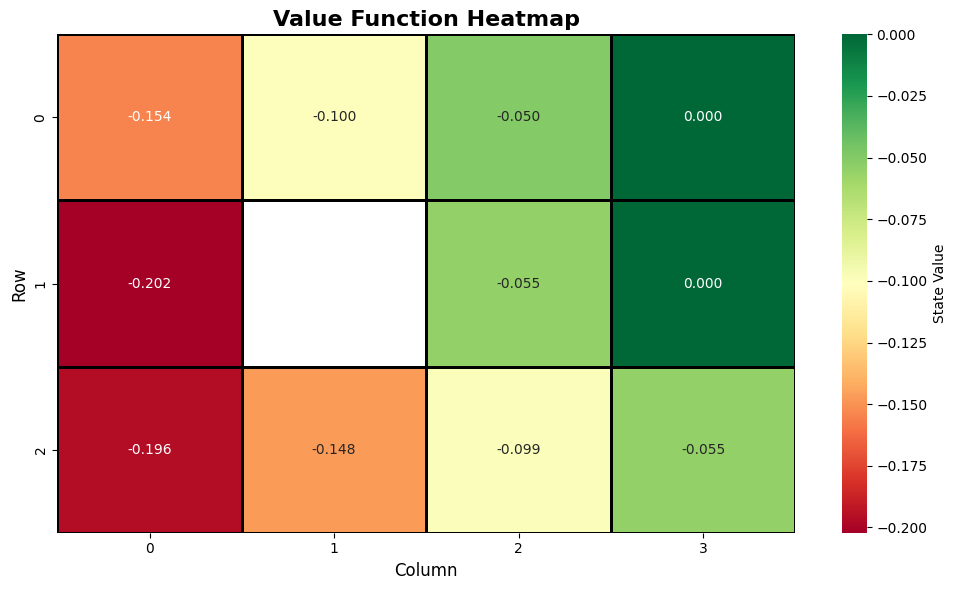


Optimal Policy (Arrows):
  →    |   →    |   →    |   T   
----------------------------------------
  ↑    |  WALL  |   →    |   T   
----------------------------------------
  →    |   →    |   →    |   ↑   

Legend: ↑=up, ↓=down, ←=left, →=right, T=Terminal, WALL=Wall


In [12]:
# Task 4: Visualization Functions

def visualize_value_function(V, rows=3, cols=4):
    """Visualize the value function as a heatmap."""
    grid = np.zeros((rows, cols))
    
    for state, value in V.items():
        r, c = state
        grid[r, c] = value
    
    # Mark wall with NaN for visualization
    grid[1, 1] = np.nan
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(grid, annot=True, fmt='.3f', cmap='RdYlGn', 
                cbar_kws={'label': 'State Value'}, 
                linewidths=2, linecolor='black')
    plt.title('Value Function Heatmap', fontsize=16, fontweight='bold')
    plt.xlabel('Column', fontsize=12)
    plt.ylabel('Row', fontsize=12)
    plt.tight_layout()
    plt.show()


def visualize_policy(policy, rows=3, cols=4):
    """Visualize the policy as arrows in a grid."""
    # Action to arrow mapping
    arrow_map = {
        'up': '↑',
        'down': '↓',
        'left': '←',
        'right': '→',
        None: 'T'  # Terminal
    }
    
    # Create grid for visualization
    grid = [['' for _ in range(cols)] for _ in range(rows)]
    
    for state, action in policy.items():
        r, c = state
        grid[r][c] = arrow_map.get(action, '')
    
    # Mark wall
    grid[1][1] = 'WALL'
    
    # Print grid
    print("\nOptimal Policy (Arrows):")
    print("=" * 40)
    for r in range(rows):
        row_str = " | ".join(f"{grid[r][c]:^6}" for c in range(cols))
        print(row_str)
        if r < rows - 1:
            print("-" * 40)
    print("=" * 40)
    print("\nLegend: ↑=up, ↓=down, ←=left, →=right, T=Terminal, WALL=Wall")


# Visualize results
print("\n" + "="*50)
print("RESULTS WITH DEFAULT PARAMETERS (R = -0.04)")
print("="*50)

visualize_value_function(V_optimal)
visualize_policy(policy)


#### Experiment with Living Penalty = 0.0


EXPERIMENT: Living Penalty = 0.0
Converged after 1 iterations


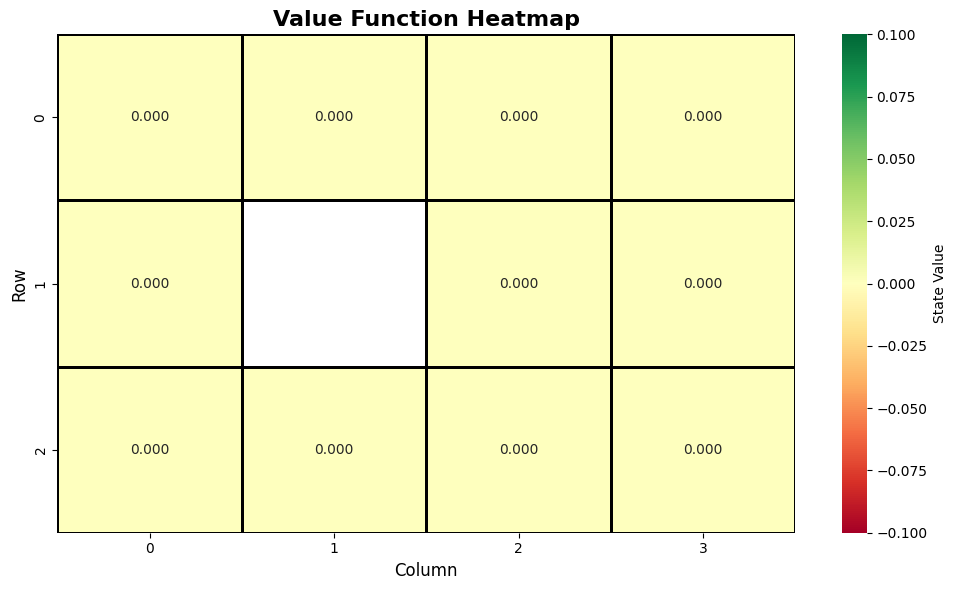


Optimal Policy (Arrows):
  ↑    |   ↑    |   ↑    |   T   
----------------------------------------
  ↑    |  WALL  |   ↑    |   T   
----------------------------------------
  ↑    |   ↑    |   ↑    |   ↑   

Legend: ↑=up, ↓=down, ←=left, →=right, T=Terminal, WALL=Wall


In [13]:
# Experiment with living penalty = 0.0

def get_reward_zero(state):
    if state == GOAL:
        return 1
    elif state == PIT:
        return -1
    else:
        return 0.0  # No living penalty

# Temporarily replace get_reward
original_get_reward = get_reward
get_reward = get_reward_zero

print("\n" + "="*50)
print("EXPERIMENT: Living Penalty = 0.0")
print("="*50)

# Run value iteration
V_zero = value_iteration(states, actions, gamma)
policy_zero = extract_policy(V_zero, states, actions, gamma)

# Visualize
visualize_value_function(V_zero)
visualize_policy(policy_zero)

# Restore original reward function
get_reward = original_get_reward


#### Question 3: Experiment with Living Penalty = -0.5


EXPERIMENT: Living Penalty = -0.5
Converged after 13 iterations


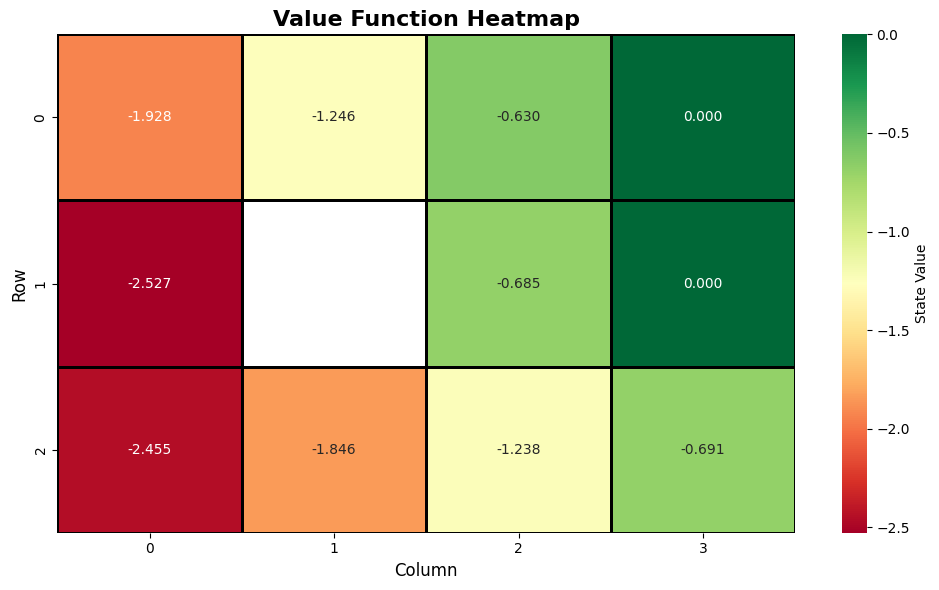


Optimal Policy (Arrows):
  →    |   →    |   →    |   T   
----------------------------------------
  ↑    |  WALL  |   →    |   T   
----------------------------------------
  →    |   →    |   →    |   ↑   

Legend: ↑=up, ↓=down, ←=left, →=right, T=Terminal, WALL=Wall


In [14]:
# Experiment with living penalty = -0.5

def get_reward_high_penalty(state):
    if state == GOAL:
        return 1
    elif state == PIT:
        return -1
    else:
        return -0.5  # High living penalty

# Temporarily replace get_reward
get_reward = get_reward_high_penalty

print("\n" + "="*50)
print("EXPERIMENT: Living Penalty = -0.5")
print("="*50)

# Run value iteration
V_high = value_iteration(states, actions, gamma)
policy_high = extract_policy(V_high, states, actions, gamma)

# Visualize
visualize_value_function(V_high)
visualize_policy(policy_high)

# Restore original reward function
get_reward = original_get_reward